In [1]:
import sys
sys.path.append("/home/conradb/git/ifg-ssl")
import os
import torch
import torchvision.transforms.v2 as transforms 
import numpy as np
import matplotlib.pyplot as plt
import random
from PIL import ImageFile

import MAE.models_mae as models_mae

In [2]:
hephaestus_mean = np.array([0.6077, 0.6077, 0.6077])
hephaestus_std = np.array([0.2037, 0.2037, 0.2037])

In [18]:
def show_image(image, title=''):
    # image is [H x W x 3]
    assert image.shape[2] == 3
    plt.imshow(torch.clip((image* hephaestus_std + hephaestus_mean)* 255, 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis('off')
    return

def prepare_model(chkpt_dir, arch='mae_vit_base_patch16'):
    model = getattr(models_mae, arch)()
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    print(msg)
    return model

def run_one_image(img, model):
    x = torch.tensor(img)
    x = x.unsqueeze(dim=0)
    print(x.shape)
    x = torch.einsum('nhwc->nchw', x)
    print(x.shape)

    loss, y, mask = model(x.float(), mask_ratio=0.60)
    y = model.unpatchify(y)
    y = torch.einsum('nchw->nhwc', y).detach().cpu()

    mask = mask.detach()
    mask = mask.unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[0]**2 *3)  # (N, H*W, p*p*3)
    mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
    mask = torch.einsum('nchw->nhwc', mask).detach().cpu()

    x = torch.einsum('nchw->nhwc', x)

    # masked image
    im_masked = x * (1 - mask)

    # MAE reconstruction pasted with visible patches
    im_paste = x * (1 - mask) + y * mask

    # make the plt figure larger
    plt.rcParams['figure.figsize'] = [24, 24]

    plt.subplot(1, 4, 1)
    show_image(x[0], "original")

    plt.subplot(1, 4, 2)
    show_image(im_masked[0], "masked")

    plt.subplot(1, 4, 3)
    show_image(y[0], "reconstruction")

    plt.subplot(1, 4, 4)
    show_image(im_paste[0], "reconstruction + visible")

    plt.show()


<PIL.Image.Image image mode=RGB size=839x766 at 0x7FDB5D6658E0>
<PIL.Image.Image image mode=RGB size=224x224 at 0x7FDB5D692A30>
(224, 224, 3)


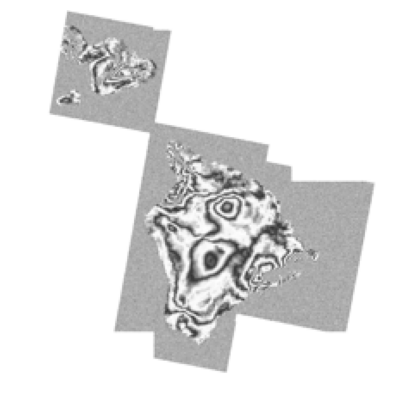

In [43]:
# 2018 Kīlauea 
# U:\scratch\SDF25\LiCSAR-web-tools\087D_07004_060904\interferograms\20180411_20180511\20180411_20180511.geo.diff.png
# U:\scratch\SDF25\LiCSAR-web-tools\087D_07004_060904\interferograms\20180423_20180505\20180423_20180505.geo.diff.png

# img_path = '/scratch/SDF25/LiCSAR-web-tools/087D_07004_060904/interferograms/20180411_20180511/20180411_20180511.geo.diff.png'
img_path = '/scratch/SDF25/LiCSAR-web-tools/087D_07004_060904/interferograms/20180423_20180505/20180423_20180505.geo.diff.png'

img = ImageFile.Image.open(img_path).convert('RGB')
print(img)
img = img.resize((224,224))
print(img)
t = transforms.Compose([transforms.Grayscale(num_output_channels=3)])
img = t(img)
# img = np.tile(np.array(img), (3,1,1)).transpose(1,2,0)/255
# print(img.shape)
img = np.array(img) /255
print(img.shape)
assert img.shape == (224, 224, 3)

img = img - hephaestus_mean
img = img / hephaestus_std

plt.rcParams['figure.figsize'] = [10, 5]
show_image(torch.tensor(img))

torch.Size([3, 224, 224])
tensor([[-1.5972e+00, -1.8860e+00, -1.8282e+00,  ...,  2.5097e-01,
          3.8574e-01,  4.0499e-01],
        [-1.5202e+00, -1.6357e+00, -1.4624e+00,  ...,  3.6648e-01,
          4.8199e-01,  4.4349e-01],
        [-1.5587e+00, -1.6164e+00, -1.0389e+00,  ...,  2.1247e-01,
          9.6961e-02,  1.7397e-01],
        ...,
        [ 1.7334e+00,  1.8104e+00,  1.7719e+00,  ...,  2.5097e-01,
          1.3546e-01,  2.8948e-01],
        [ 1.7911e+00,  1.7911e+00,  1.6371e+00,  ...,  7.0280e-04,
          5.8458e-02,  2.1247e-01],
        [ 6.1676e-01,  5.3975e-01,  4.2424e-01,  ...,  7.0280e-04,
          2.8948e-01,  1.1621e-01]], dtype=torch.float64)
tensor([[0.2588, 0.2314, 0.2745,  ..., 0.6157, 0.6588, 0.6431],
        [0.2863, 0.2314, 0.2314,  ..., 0.8431, 0.7412, 0.7412],
        [0.3137, 0.2314, 0.3569,  ..., 0.6588, 0.6431, 0.5569],
        ...,
        [0.9529, 0.9686, 1.0000,  ..., 0.6157, 0.6157, 0.6157],
        [0.9686, 0.9686, 0.9686,  ..., 0.6157, 0.643

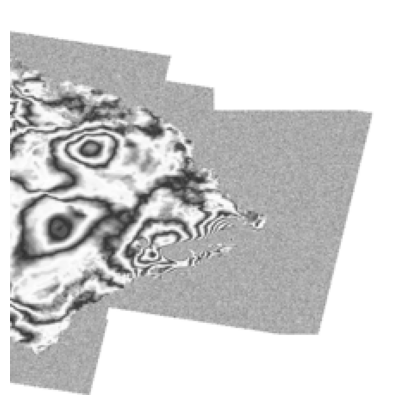

In [73]:
#Transform Grayscale + ToTensor (which normalizes /255)
seed = 41
torch.manual_seed(seed)
random.seed(seed)

img1 = ImageFile.Image.open(img_path).convert('RGB')
# img1 = img1.resize((224,224))
img2 = ImageFile.Image.open(img_path)
# img2 = img2.resize((224,224))
transform = transforms.Compose([transforms.RandomResizedCrop(224, scale=(0.15, 1.0), interpolation=3), transforms.Grayscale(num_output_channels=3), transforms.ToTensor()])
# transform = transforms.Compose([transforms.CenterCrop(size=(224,224)), transforms.Grayscale(num_output_channels=3), transforms.ToTensor()])

img1, img2 = transform(img1, img2)
print(img1.shape)

img1 = img1.permute(1,2,0) - hephaestus_mean
img1 = img1 / hephaestus_std

show_image(img1)

print(img1[100:150, 100:150, 0])
print(img2[0, 100:150, 100:150])

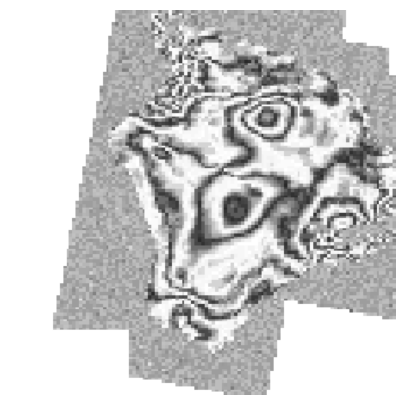

In [277]:
show_image(img2.permute(1,2,0))

In [12]:
# chkpt_dir = '/home/conradb/git/ifg-ssl/hephaestus/checkpoints/Hephaestus_MAE_VitB16_224_no_os_no_norm_2000e_75msk_1-5e4lr.pth'
chkpt_dir = '/home/conradb/git/ifg-ssl/hephaestus/checkpoints/Hephaestus_MAE_VitB16_224_no_os_norm_1000e_60msk_1-5e4lr.pth'
model_mae = prepare_model(chkpt_dir, 'mae_vit_base_patch16')

<All keys matched successfully>


/tmp/ipykernel_216526/1508970794.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(img)


torch.Size([1, 224, 224, 3])
torch.Size([1, 3, 224, 224])


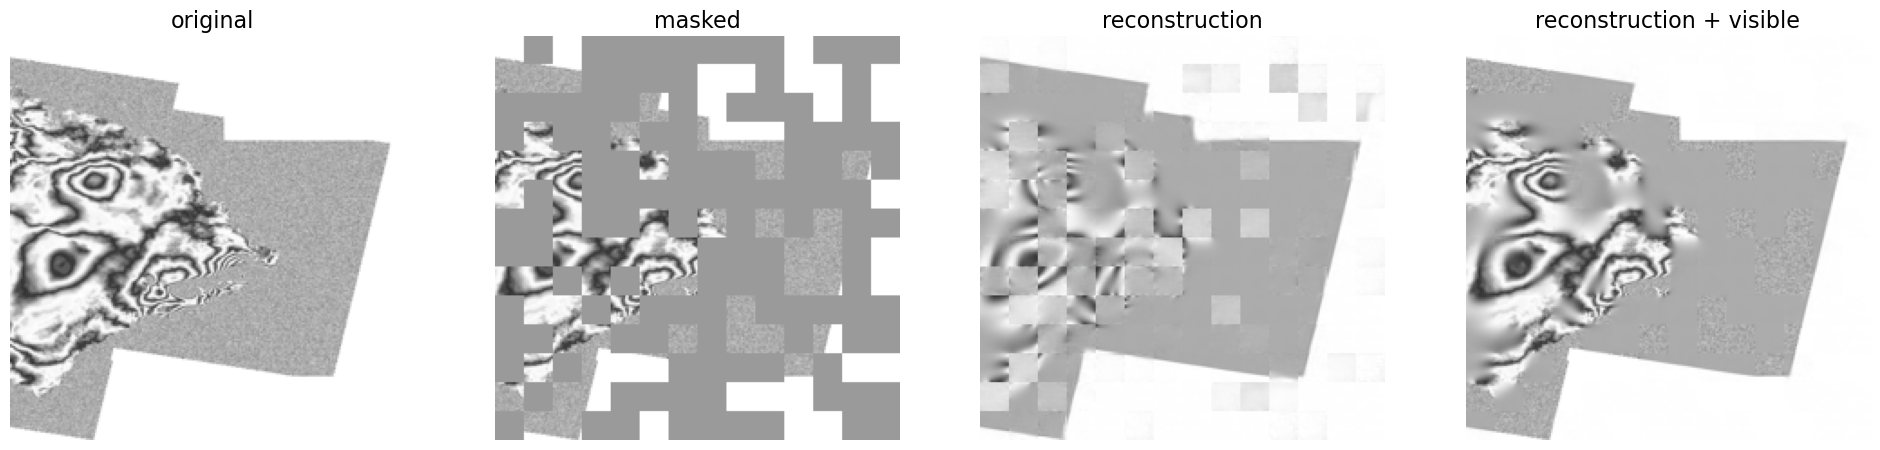

In [74]:
run_one_image(img1, model_mae)

/tmp/ipykernel_216526/1508970794.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(img)


torch.Size([1, 224, 224, 3])
torch.Size([1, 3, 224, 224])


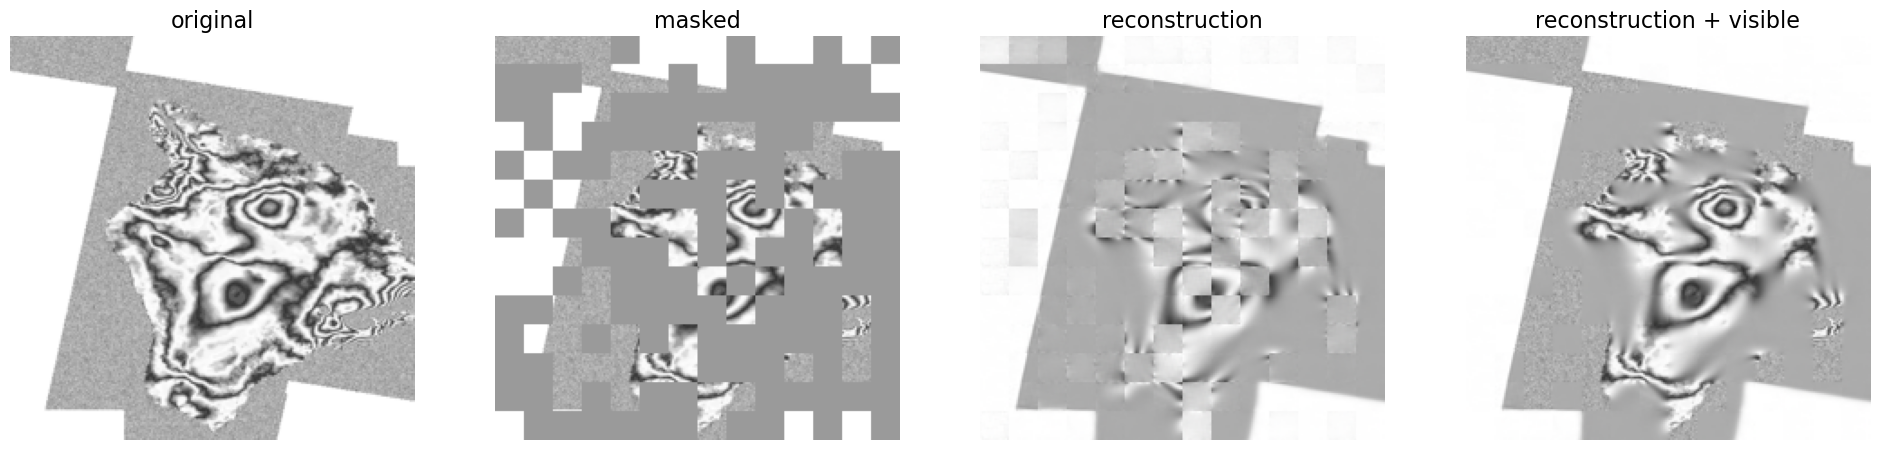

In [20]:
run_one_image(img1, model_mae)